# WaveNet Sample Generation
Fast generation of samples from a pretrained WaveNet model

In [9]:
from wavenet_model import WaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Load Model

In [10]:
train_samples = ["train_samples/sine.wav"]
sampling_rate = 44100

parameters = "model_parameters/violin_7-2-128-64-64-64-2"

layers = 7
blocks = 2
classes = 128
dilation_channels = 64
residual_channels = 64
skip_channels = 64
kernel_size = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [11]:
model = WaveNetModel(layers=layers,
                     blocks=blocks,
                     dilation_channels=dilation_channels,
                     residual_channels=residual_channels,
                     skip_channels=skip_channels,
                     classes=classes,
                     kernel_size=kernel_size,
                     dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)

if use_cuda:
    model.load_state_dict(torch.load(parameters))
else:
    # move to cpu
    model.load_state_dict(torch.load(parameters, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              receptive_field=model.receptive_field,
                              target_length=model.output_length,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive_field:  318
total duration of training data:  0.4876190476190476  s


There are not enough segments available in the training set to produce one chunk
load new chunk with start segment index  0
loading this chunk took  0.012977838516235352  seconds
use loaded chunk with  16 segments
load new chunk with start segment index  7


<IPython.core.display.Javascript object>


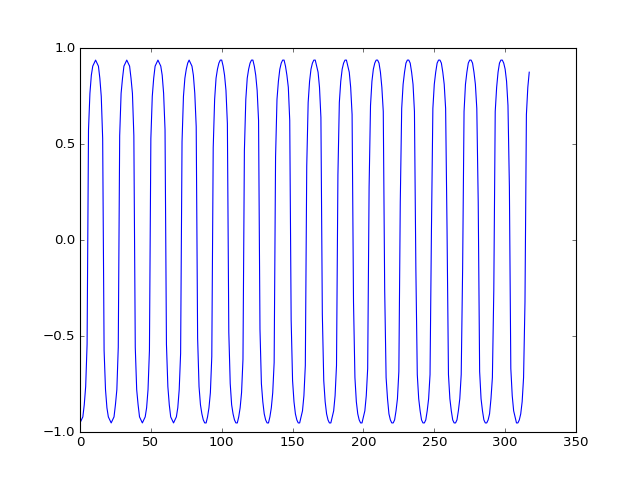

In [12]:
data_loader.start_new_epoch()
data_loader.load_new_chunk()
data_loader.use_new_chunk()
start_data = data_loader.get_minibatch(1)[0]
start_data = start_data.squeeze()
#start_tensor = torch.zeros((model.scope)) + 0.0

plt.plot(start_data.cpu().numpy()[:])

## Generate Samples


In [13]:
num_samples = 20000 # number of samples that will be generated
out_file = "generated_samples/violin_7-2-128-32-32-32-2.wav"

In [14]:
from ipywidgets import FloatProgress
from IPython.display import display
progress = FloatProgress(min=0, max=100)
display(progress)

def p_callback(i, total):
    progress.value += 1

tic = time.time()
generated_sample = model.generate_fast(num_samples, 
                                       first_samples=start_data,
                                       #first_samples=torch.zeros((1)),
                                       progress_callback=p_callback,
                                       sampled_generation=False,
                                       temperature=1.0)
toc = time.time()
print('Generating took {} seconds.'.format(toc-tic))

Generating took 104.95936703681946 seconds.


<IPython.core.display.Javascript object>


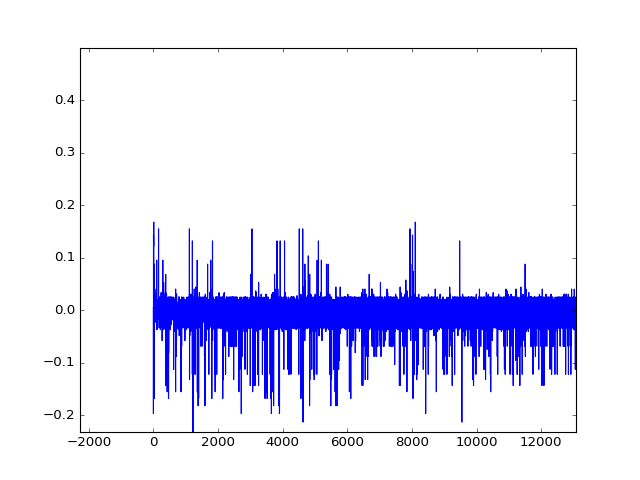

In [15]:
fig = plt.figure()
plt.plot(generated_sample)

from IPython.display import Audio
Audio(np.array(generated_sample), rate=sampling_rate)

In [ ]:
print(np.array(generated_sample))

from scipy.io import wavfile
wavfile.write(out_file, sampling_rate, np.array(generated_sample))